TensorFlow Version: 2.18.0
No GPU detected. Training will run on CPU.
Scene 1352890817715: Filtering 1 nodes with NaN values.
Scene 1352890817715 contains -1 edges. Removing these edges.
Scene 1352890814428: Filtering 1 nodes with NaN values.
Scene 1352890814428 contains -1 edges. Removing these edges.
Scene 1352890802323 contains -1 edges. Removing these edges.
Scene 1352890800322: Filtering 1 nodes with NaN values.
Scene 1352890800322 contains -1 edges. Removing these edges.
Scene 1352890875617 contains -1 edges. Removing these edges.
Scene 1352890804562: Filtering 1 nodes with NaN values.
Scene 1352890804562 contains -1 edges. Removing these edges.
Scene 1352890841688: Filtering 1 nodes with NaN values.
Scene 1352890841688 contains -1 edges. Removing these edges.
Scene 1352890837555 contains -1 edges. Removing these edges.
Scene 1352890825684 contains -1 edges. Removing these edges.
Scene 1352890801553: Filtering 1 nodes with NaN values.
Scene 1352890801553 contains -1 edges. Removi

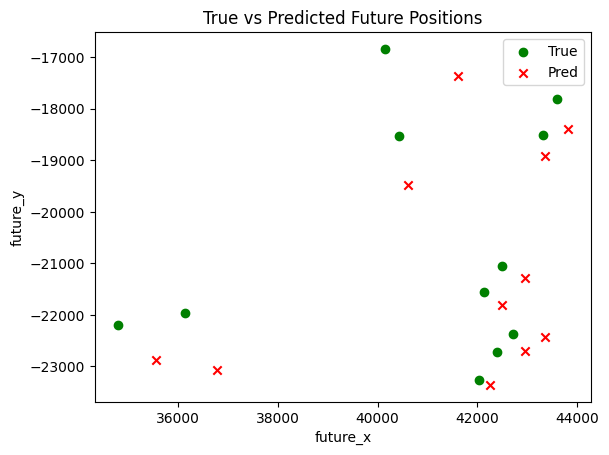

Running time: 0 hours, 0 minutes, 54 seconds


In [25]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
import time

dataset_dir = "dataset"

warnings.filterwarnings("ignore")
np.random.seed(2)
tf.random.set_seed(2)

print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], "GPU")
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Training will run on CPU.")

start_time = time.time()


# Data loading functions
def find_all_scene_ids(dataset_dir):
    scene_ids = []
    for file in os.listdir(dataset_dir):
        if file.endswith(".edges"):
            scene_id = file.split(".")[0]
            scene_ids.append(scene_id)
    return scene_ids


def load_all_subgraphs(dataset_dir):
    scene_ids = find_all_scene_ids(dataset_dir)
    scenes = []
    for scene_id in scene_ids:
        edges_file = os.path.join(dataset_dir, f"{scene_id}.edges")
        nodes_file = os.path.join(dataset_dir, f"{scene_id}.nodes")
        if not os.path.exists(edges_file) or not os.path.exists(nodes_file):
            print(f"Skipping scene ID {scene_id}: Missing files.")
            continue

        # Load edges and nodes.
        edges = pd.read_csv(edges_file, sep=",", header=None, names=["target", "source"])
        nodes = pd.read_csv(
            nodes_file,
            sep=",",
            header=None,
            names=["node_id", "current_x", "current_y", "previous_x", "previous_y", "future_x", "future_y"],
        )
        for col in nodes.columns:
            nodes[col] = pd.to_numeric(nodes[col], errors="coerce")
        if nodes.isnull().any().any():
            nan_nodes = nodes[nodes.isnull().any(axis=1)]
            nan_node_ids = nan_nodes["node_id"].tolist()
            print(f"Scene {scene_id}: Filtering {len(nan_node_ids)} nodes with NaN values.")
            edges = edges[~edges["source"].isin(nan_node_ids) & ~edges["target"].isin(nan_node_ids)]
            nodes = nodes.dropna(subset=["future_x", "future_y"])
        if (edges["source"] == -1).any() or (edges["target"] == -1).any():
            print(f"Scene {scene_id} contains -1 edges. Removing these edges.")
            edges = edges[(edges["source"] != -1) & (edges["target"] != -1)]
            connected_nodes = pd.unique(edges[["target", "source"]].values.ravel())
            nodes = nodes[nodes["node_id"].isin(connected_nodes)]
        # Only append scenes with at least one node
        if len(nodes) > 0:
            scenes.append({"scene_id": scene_id, "edges": edges, "nodes": nodes})
        else:
            print(f"NOTE! Scene {scene_id} skipped: no valid nodes after filtering.")
    return scenes


# Define feature and target columns
feature_cols = ["current_x", "current_y", "previous_x", "previous_y"]
target_cols = ["future_x", "future_y"]


# def convert_scene_to_tensors(scene):
#     nodes_df = scene["nodes"].reset_index(drop=True)
#     edges_df = scene["edges"].reset_index(drop=True)
#     features = nodes_df[feature_cols].to_numpy().astype(np.float32)
#     targets = nodes_df[target_cols].to_numpy().astype(np.float32)
#     edges = edges_df.to_numpy().astype(np.int32)
#     return features, edges, targets


def convert_scene_to_tensors(scene):
    nodes_df = scene["nodes"].reset_index(drop=True)
    edges_df = scene["edges"].reset_index(drop=True)
    # Map node_id to local index
    node_id_to_idx = {nid: i for i, nid in enumerate(nodes_df["node_id"])}
    # Remap edges to local indices
    edges_df = edges_df.copy()
    edges_df["target"] = edges_df["target"].map(node_id_to_idx)
    edges_df["source"] = edges_df["source"].map(node_id_to_idx)
    # Drop edges with missing nodes (after mapping)
    edges_df = edges_df.dropna().astype(int)
    features = nodes_df[feature_cols].to_numpy().astype(np.float32)
    targets = nodes_df[target_cols].to_numpy().astype(np.float32)
    edges = edges_df.to_numpy().astype(np.int32)
    return features, edges, targets


def split_scenes(scenes, train_ratio=0.7, val_ratio=0.15):
    np.random.shuffle(scenes)
    n_total = len(scenes)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    train_scenes = scenes[:n_train]
    val_scenes = scenes[n_train : n_train + n_val]
    test_scenes = scenes[n_train + n_val :]
    return train_scenes, val_scenes, test_scenes


scenes = load_all_subgraphs(dataset_dir)
print(f"Loaded {len(scenes)} scenes.")
train_scenes, val_scenes, test_scenes = split_scenes(scenes, train_ratio=0.7, val_ratio=0.15)
print(f"Train scenes: {len(train_scenes)}, Val scenes: {len(val_scenes)}, Test scenes: {len(test_scenes)}")


# # 1. Fit scalers on training data
# all_train_features = np.vstack([scene["nodes"][feature_cols].values for scene in train_scenes])
# all_train_targets = np.vstack([scene["nodes"][target_cols].values for scene in train_scenes])
# feature_scaler = StandardScaler().fit(all_train_features)
# target_scaler = StandardScaler().fit(all_train_targets)


# # 2. Use scalers in tensor conversion
# def convert_scene_to_tensors(scene):
#     nodes_df = scene["nodes"].reset_index(drop=True)
#     edges_df = scene["edges"].reset_index(drop=True)
#     node_id_to_idx = {nid: i for i, nid in enumerate(nodes_df["node_id"])}
#     edges_df = edges_df.copy()
#     edges_df["target"] = edges_df["target"].map(node_id_to_idx)
#     edges_df["source"] = edges_df["source"].map(node_id_to_idx)
#     edges_df = edges_df.dropna().astype(int)
#     features = feature_scaler.transform(nodes_df[feature_cols].to_numpy().astype(np.float32))
#     targets = target_scaler.transform(nodes_df[target_cols].to_numpy().astype(np.float32))
#     edges = edges_df.to_numpy().astype(np.int32)
#     return features, edges, targets


def scene_generator(scene_list):
    for scene in scene_list:
        yield convert_scene_to_tensors(scene)


train_dataset = tf.data.Dataset.from_generator(
    lambda: scene_generator(train_scenes),
    output_signature=(
        tf.TensorSpec(shape=(None, len(feature_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.int32),
        tf.TensorSpec(shape=(None, len(target_cols)), dtype=tf.float32),
    ),
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: scene_generator(val_scenes),
    output_signature=(
        tf.TensorSpec(shape=(None, len(feature_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.int32),
        tf.TensorSpec(shape=(None, len(target_cols)), dtype=tf.float32),
    ),
)
test_dataset = tf.data.Dataset.from_generator(
    lambda: scene_generator(test_scenes),
    output_signature=(
        tf.TensorSpec(shape=(None, len(feature_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.int32),
        tf.TensorSpec(shape=(None, len(target_cols)), dtype=tf.float32),
    ),
)


def squeeze_batch(features, edges, targets):
    return tf.squeeze(features, axis=0), tf.squeeze(edges, axis=0), tf.squeeze(targets, axis=0)


train_dataset = train_dataset.shuffle(100).batch(1).map(squeeze_batch)
val_dataset = val_dataset.batch(1).map(squeeze_batch)
test_dataset = test_dataset.batch(1).map(squeeze_batch)


# -------------------------
# Define Model Components
# -------------------------
class GraphAttention(layers.Layer):
    def __init__(self, units, kernel_initializer="glorot_uniform", kernel_regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        super().build(input_shape)

    def call(self, inputs):
        node_states, edges = inputs
        node_states_transformed = tf.matmul(node_states, self.kernel)
        target_states = tf.gather(node_states_transformed, edges[:, 0])
        source_states = tf.gather(node_states_transformed, edges[:, 1])
        concat_features = tf.concat([target_states, source_states], axis=-1)
        attention_scores = tf.nn.leaky_relu(tf.matmul(concat_features, self.kernel_attention))
        attention_scores = tf.squeeze(attention_scores, axis=-1)
        attention_scores = tf.exp(tf.clip_by_value(attention_scores, -2, 2))
        num_nodes = tf.shape(node_states)[0]
        attention_sum = tf.math.unsorted_segment_sum(attention_scores, segment_ids=edges[:, 0], num_segments=num_nodes)
        normalized_attention = attention_scores / tf.gather(attention_sum, edges[:, 0])
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * normalized_attention[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=num_nodes,
        )
        return out


class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        node_features, edges = inputs
        outputs = [attn([node_features, edges]) for attn in self.attention_layers]
        if self.merge_type == "concat":
            out = tf.concat(outputs, axis=-1)
        else:
            out = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        return tf.nn.relu(out)


class GraphAttentionNetwork(keras.Model):
    def __init__(self, hidden_units, num_heads, num_layers, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs, training=False):
        # Since our dataset is unbatched, node_features is expected to have shape [n_nodes, feature_dim]
        node_features, edges = inputs

        # Directly use inputs since no batch dimension is present.
        x = self.preprocess(node_features)
        for attn_layer in self.attention_layers:
            x_new = attn_layer([x, edges])
            x = x + x_new  # residual connection
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        node_features, edges, targets = data
        with tf.GradientTape() as tape:
            outputs = self([node_features, edges], training=True)
            loss = self.compiled_loss(targets, outputs)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(targets, outputs)
        logs = {m.name: m.result() for m in self.metrics}
        logs["loss"] = loss
        return logs

    def predict_step(self, data):
        node_features, edges, _ = data
        outputs = self([node_features, edges], training=False)
        return outputs

    def test_step(self, data):
        node_features, edges, targets = data
        outputs = self([node_features, edges], training=False)
        loss = self.compiled_loss(targets, outputs)
        self.compiled_metrics.update_state(targets, outputs)
        logs = {m.name: m.result() for m in self.metrics}
        logs["loss"] = loss
        return logs


# -------------------------
# Model Training & Evaluation
# -------------------------
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = 2
NUM_EPOCHS = 100
LEARNING_RATE = 1e-2

def mean_euclidean_distance(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_true - y_pred, axis=-1))

loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.R2Score(),
    keras.metrics.MeanMetricWrapper(mean_euclidean_distance, name="mean_euclidean_distance"),
]

gat_model = GraphAttentionNetwork(
    hidden_units=HIDDEN_UNITS,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    output_dim=OUTPUT_DIM,
)

gat_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-5, patience=15, verbose=1, restore_best_weights=True, start_from_epoch=0
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=5, verbose=1, min_delta=1e-4, min_lr=1e-6
)


print("Training...")
history = gat_model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping],
    verbose=2,
)


print("Evaluating on test dataset...")
results = gat_model.evaluate(test_dataset, verbose=2)
print("Test metrics:", results)

# # 3. Inverse-transform predictions for interpretability
# for features, edges, targets in test_dataset.take(1):
#     predictions = gat_model((features, edges), training=False)
#     # Inverse-transform for readability
#     predictions_orig = target_scaler.inverse_transform(predictions.numpy())
#     targets_orig = target_scaler.inverse_transform(targets.numpy())
#     for i in range(min(5, predictions.shape[0])):
#         print(
#             f"Node {i}: True future_x={targets_orig[i, 0]:.1f}, future_y={targets_orig[i, 1]:.1f} | "
#             f"Predicted future_x={predictions_orig[i, 0]:.1f}, future_y={predictions_orig[i, 1]:.1f}"
#         )

# # --- Compute metrics in original scale ---


# # Collect all predictions and targets
# all_preds = []
# all_targets = []
# for features, edges, targets in test_dataset:
#     preds = gat_model((features, edges), training=False)
#     all_preds.append(preds.numpy())
#     all_targets.append(targets.numpy())

# all_preds = np.vstack(all_preds)
# all_targets = np.vstack(all_targets)

# # Inverse transform
# all_preds_orig = target_scaler.inverse_transform(all_preds)
# all_targets_orig = target_scaler.inverse_transform(all_targets)

# # Compute metrics
# mae_orig = mean_absolute_error(all_targets_orig, all_preds_orig)
# mse_orig = mean_squared_error(all_targets_orig, all_preds_orig)
# euclidean_orig = np.mean(np.linalg.norm(all_targets_orig - all_preds_orig, axis=1))

# print(f"Test MAE (original scale): {mae_orig:.4f}")
# print(f"Test MSE (original scale): {mse_orig:.4f}")
# print(f"Test Mean Euclidean Distance (original scale): {euclidean_orig:.4f}")

print("\nSample predictions for test scenes:")
for features, edges, targets in test_dataset.take(1):
    predictions = gat_model((features, edges), training=False)
    for i in range(min(5, predictions.shape[0])):
        print(
            f"Node {i}: True future_x={targets[i, 0]:.1f}, future_y={targets[i, 1]:.1f} | Predicted future_x={predictions[i, 0]:.1f}, future_y={predictions[i, 1]:.1f}"
        )

# plt.scatter(all_targets_orig[:20, 0], all_targets_orig[:20, 1], label="True", c="g")
# plt.scatter(all_preds_orig[:20, 0], all_preds_orig[:20, 1], label="Pred", c="r", marker="x")
# plt.legend()
# plt.xlabel("future_x")
# plt.ylabel("future_y")
# plt.title("True vs Predicted Future Positions")
# plt.show()

plt.scatter(targets[:20, 0], targets[:20, 1], label="True", c="g")
plt.scatter(predictions[:20, 0], predictions[:20, 1], label="Pred", c="r", marker="x")
plt.legend()
plt.xlabel("future_x")
plt.ylabel("future_y")
plt.title("True vs Predicted Future Positions")
plt.show()

end_time = time.time()
running_time = end_time - start_time
hours = int(running_time // 3600)
minutes = int((running_time % 3600) // 60)
seconds = int(running_time % 60)
print(f"Running time: {hours} hours, {minutes} minutes, {seconds} seconds")